<a href="https://colab.research.google.com/github/lmartinelli71/financialProjects/blob/main/Procesamiento_satelitales_campos.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Cada subcarpeta contiene:  
- una **Imagen satelital Sentinel 2** del año 2024 con las siguientes bandas "B2", "B3", "B4", "B8", "B11", "B12".

In [ ]:
#importar la biblioteca drive en la notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys, os
ruta_base = '/content/drive/MyDrive/1_No estructurados/Maestria_GyADF/Imagenes_satelitales'

In [ ]:
#Se carga rasterio
!pip3 install rasterio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.5/21.5 MB 34.3 MB/s eta 0:00:00


In [ ]:
#Importacion de librerias
import numpy as np
import matplotlib.pyplot as plt
import os

import rasterio
import rasterio.mask


from rasterio.plot import show
from rasterio.plot import show_hist
from rasterio.mask import mask

import geopandas as gpd
from shapely.geometry import mapping

import pandas as pd
import seaborn as sns


Se lee la imagen obteniendose la informacion basica y cuales son las bandas

In [ ]:
# Se lee la imagen satelital
raster_fn = os.path.join(ruta_base, 'S2_Bandera_2024_03_24_B2_3_4_8_11_12.tif')
print(raster_fn)

#Se obtienen metadatos
with rasterio.open(raster_fn) as src:
    img = src.read()
    gt = src.transform
    crs = src.crs
    band_names = src.descriptions

num_bandas = src.count

#Se muestra la informacion basica
print('El numero de bandas es: ',num_bandas)
print('Las bandas son: ',band_names)
print('Forma de la imagen:', img.shape)
print('Tipo de datos de la imagen:', src.dtypes)
print('Sistema de referencia de coordenadas: ',crs)

/content/drive/MyDrive/1_No estructurados/Maestria_GyADF/Imagenes_satelitales/S2_Bandera_2024_03_24_B2_3_4_8_11_12.tif
El numero de bandas es:  6
Las bandas son:  ('B2', 'B3', 'B4', 'B8', 'B11', 'B12')
Forma de la imagen: (6, 1264, 2556)
Tipo de datos de la imagen: ('float64', 'float64', 'float64', 'float64', 'float64', 'float64')
Sistema de referencia de coordenadas:  EPSG:32720


Se abre la imagen con la librería **rasterio**, luego se realiza la visualización de la **Imagen Sentinel 2** utilizando la combinación de **falso color**, asignando a los canales RGB las bandas B8, B11 y B4 respectivamente y escalando la imagen con un valor de percentil "p" del 5%.


In [ ]:
def scale(array, p=0, nodata=None):
    '''
    Esta función escala o estira la imagen a determinado % del histograma (trabaja con percentiles).
    Si p = 0 (valor por defecto) entonces toma el mínimo y máximo de la imagen.
    Devuelve un arreglo nuevo, escalado de 0 a 1.
    '''
    a = array.copy()
    a_min, a_max = np.nanpercentile(a[a != nodata], p), np.nanpercentile(a[a != nodata], 100 - p)
    a[a < a_min] = a_min
    a[a > a_max] = a_max
    return (a - a_min) / (a_max - a_min)


In [ ]:
def get_rgb(array, band_list, p=0, nodata=None):
    '''
    Esta función toma como parámetros de entrada la matriz a ser ploteada, una lista de índices correspondientes
    a las bandas que queremos usar, en el orden que deben estar (ej: [1,2,3]), y un parámetro
    p que es opcional, y por defecto es 0 (es el estiramiento a aplicar cuando llama a scale()).

    Devuelve una matriz con las 3 bandas escaladas.

    Nota: Se espera una matriz con estas dimensiones de entrada: [bandas, filas, columnas].
    '''
    r = band_list[0]
    g = band_list[1]
    b = band_list[2]

    r1 = scale(array[r - 1, :, :], p, nodata)
    g1 = scale(array[g - 1, :, :], p, nodata)
    b1 = scale(array[b - 1, :, :], p, nodata)

    a = np.dstack((r1, g1, b1))
    return a


In [ ]:
import matplotlib.pyplot as plt

def plot_rgb(array, band_list, p=0, nodata=None, figsize=(12, 6)):
    '''
    Esta función toma como parámetros de entrada la matriz a ser ploteada, una lista de índices correspondientes
    a las bandas que queremos usar, en el orden que deben estar (ej: [1,2,3]), y un parámetro
    p que es opcional, y por defecto es 0 (es el estiramiento a aplicar cuando llama a get_rgb(), que a su vez llama a scale()).

    Por defecto también asigna un tamaño de figura en (12,6), que también puede ser modificado.

    Devuelve solamente un ploteo, no modifica el arreglo original.
    Nota: Se espera una matriz con estas dimensiones de entrada: [bandas, filas, columnas].
    '''
    r = band_list[0]
    g = band_list[1]
    b = band_list[2]

    a = get_rgb(array, band_list, p, nodata)

    plt.figure(figsize=figsize)
    plt.title(f'Combinación {r}, {g}, {b} \n (estirado al {p}%)', size=12)
    plt.imshow(a)
    plt.show()


/usr/local/lib/python3.10/dist-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


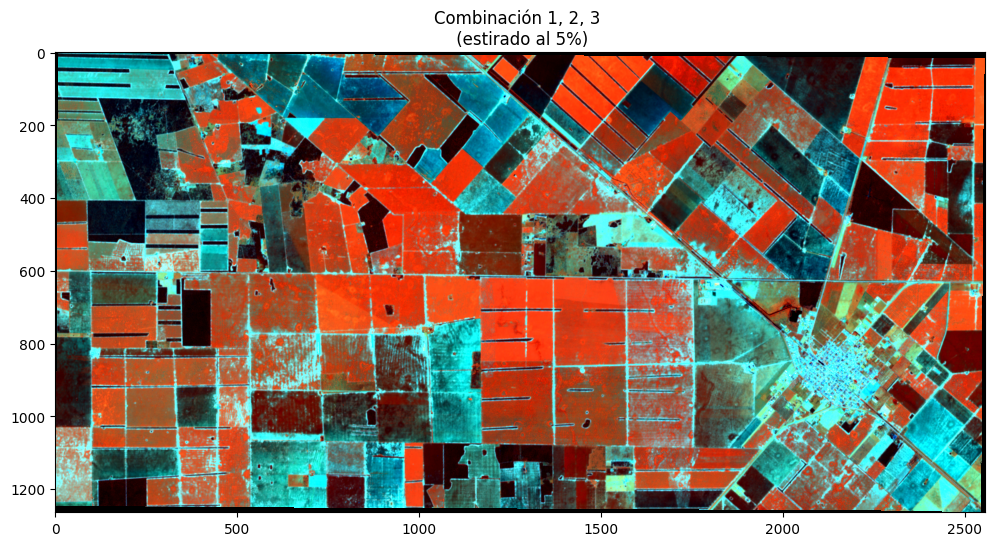

In [ ]:
# Ruta al archivo de la imagen Sentinel-2
image_path = '/content/drive/MyDrive/1_No estructurados/Maestria_GyADF/Imagenes_satelitales/S2_Bandera_2024_03_24_B2_3_4_8_11_12.tif'

# Abrir la imagen con rasterio
with rasterio.open(image_path) as src:
    # Leer las bandas B8 (banda 8), B11 (banda 11), y B4 (banda 4)
    band8 = src.read(4)
    band11 = src.read(5)
    band4 = src.read(6)

    # Crear un arreglo con las bandas seleccionadas
    array = np.stack([band8, band11, band4])

# Usar las bandas 8, 11, y 4 para el falso color en el orden RGB
band_list = [8, 11, 4]

# Visualizar la imagen
plot_rgb(array, band_list=[1, 2, 3], p=5, nodata=None)


Se calcula el índice de vegetación

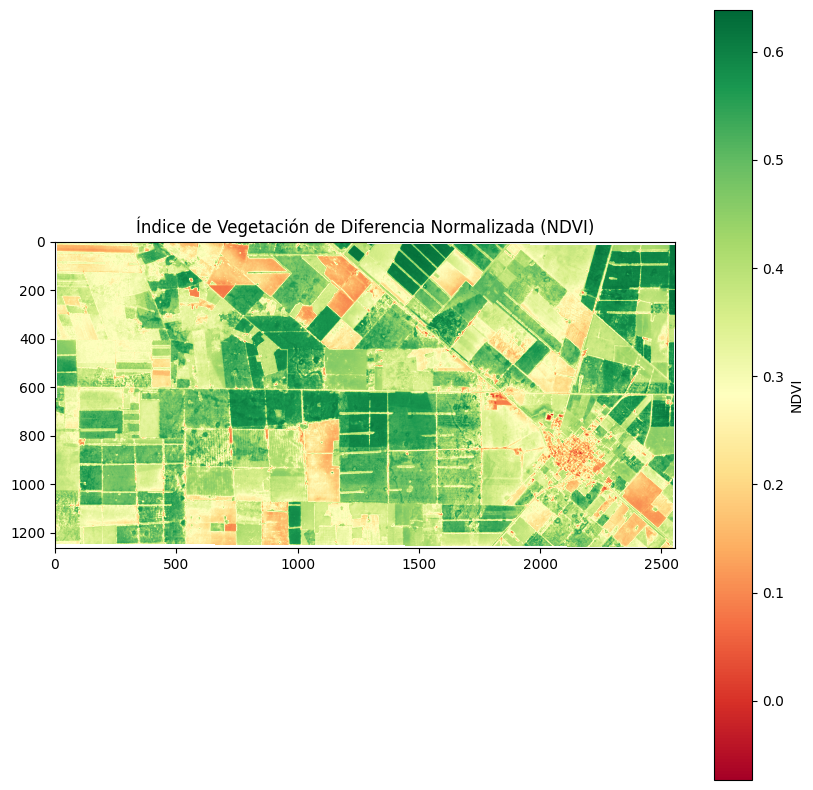

In [ ]:
# Se abre la imagen con rasterio
with rasterio.open(image_path) as src:
    # Leer las bandas NIR (banda 4) y Red (banda 3)
    nir = src.read(4)  # B8
    red = src.read(3)  # B4

# Calculamos el NDVI
ndvi = (nir.astype(float) - red.astype(float)) / (nir + red)

# Se muestra el NDVI
plt.figure(figsize=(10, 10))
plt.imshow(ndvi, cmap='RdYlGn')
plt.colorbar(label='NDVI')
plt.title('Índice de Vegetación de Diferencia Normalizada (NDVI)')
plt.show()

Se grafica el histograma de la banda 11. Calcula los valores mínimo, máximo, media y desvío estándar a partir de los valores de los píxeles.

Valor mínimo: nan
Valor máximo: nan
Valor medio: nan
Desviación estándar: nan


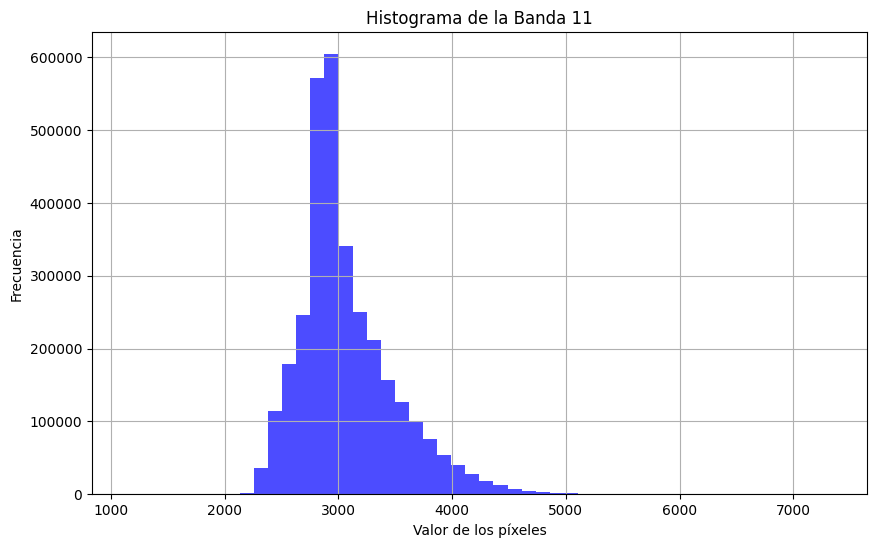

In [ ]:
# Se abre la imagen con rasterio y se lee la banda 11
with rasterio.open(image_path) as src:
    band11 = src.read(5)  # La banda 11 es la quinta en la lista

# Calculo de estadísticos básicos
min_val = band11.min()
max_val = band11.max()
mean_val = band11.mean()
std_val = band11.std()

# Impresion de los resultados
print(f'Valor mínimo: {min_val}')
print(f'Valor máximo: {max_val}')
print(f'Valor medio: {mean_val}')
print(f'Desviación estándar: {std_val}')

# Grafico del histograma de la banda 11
plt.figure(figsize=(10, 6))
plt.hist(band11.flatten(), bins=50, color='blue', alpha=0.7)
plt.title('Histograma de la Banda 11')
plt.xlabel('Valor de los píxeles')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

Se implementa una **clasificación no supervisada** sobre la imagen satelital

Se aplica una clasificación no supervisada K-means, seleccionando previamente el optimo para el número de clusters para diferenciar las coberturas en el área de estudio seleccionada.

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

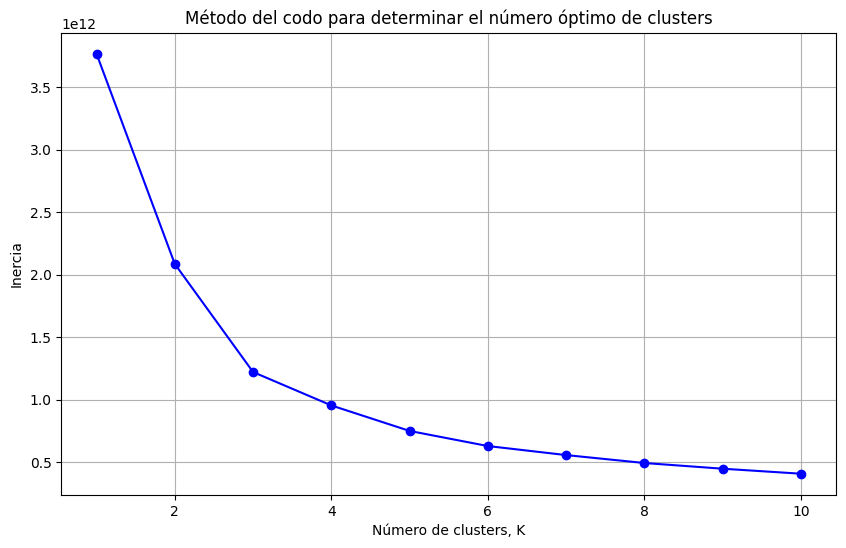

In [ ]:
from sklearn.cluster import KMeans
# Se llee la imagen y se preparan las bandas
with rasterio.open(image_path) as src:
    bands = []
    for i in range(1, 7):  # Se leen todas las bandas (B2, B3, B4, B8, B11, B12)
        bands.append(src.read(i))
    image = np.stack(bands, axis=-1)  # Stack para crear un tensor de dimensiones (1264, 2556, 6)

# Reshape de la imagen para aplicar K-means
pixels = image.reshape(-1, 6)  # Cambia la forma a (1264*2556, 6)

# Manejo de NaNs: se eliminan los píxeles con valores NaN
valid_pixels = pixels[~np.isnan(pixels).any(axis=1)]

# Con el método del codo se determina el número de clusters optimo
inertias = []
K = range(1, 11)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42).fit(valid_pixels)
    inertias.append(kmeans.inertia_)

# Se hace el grafico para obtener del mismo el numero optimo de clusters por el método del codo (cantidad de clusters=3)
plt.figure(figsize=(10, 6))
plt.plot(K, inertias, 'bo-')
plt.xlabel('Número de clusters, K')
plt.ylabel('Inercia')
plt.title('Método del codo para determinar el número óptimo de clusters')
plt.grid(True)
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


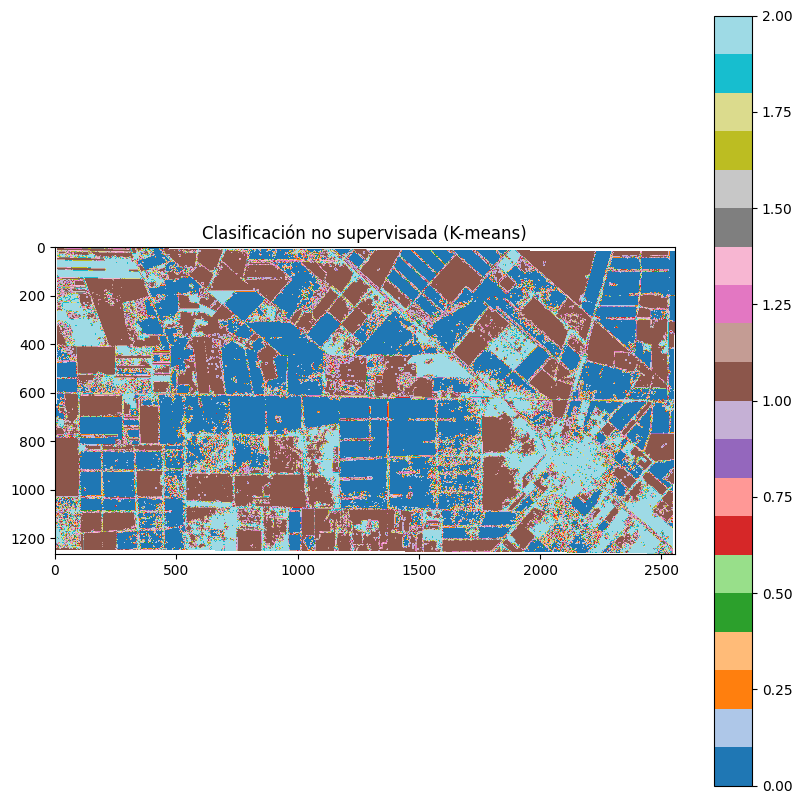

In [ ]:
# Con 3 clusters se aplica kmeans
from sklearn.cluster import KMeans

# Leer la imagen y preparar las bandas
with rasterio.open(image_path) as src:
    bands = []
    for i in range(1, 7):  # Se leen todas las bandas (B2, B3, B4, B8, B11, B12)
        bands.append(src.read(i))
    image = np.stack(bands, axis=-1)  # Stack para crear una matriz de dimensiones (1264, 2556, 6)

# Reshape de la imagen para aplicar K-means
pixels = image.reshape(-1, 6)  # Cambia la forma a (1264*2556, 6)

# Manejo de NaNs: se eliminan píxeles con valores NaN
valid_pixels = pixels[~np.isnan(pixels).any(axis=1)]

# Se aplica K-means
kmeans = KMeans(n_clusters=3, random_state=42).fit(valid_pixels)  # Utilizamos 3 clusters para esta clasificación que hallamos por el metodo del codo

# Se crea un arreglo para almacenar las etiquetas y asignar NaN donde corresponda
labels = np.full(pixels.shape[0], np.nan)
labels[~np.isnan(pixels).any(axis=1)] = kmeans.labels_

# Se reestructuran las etiquetas a la forma original de la imagen
labels = labels.reshape(image.shape[0], image.shape[1])

# Se visualizan los resultados
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='tab20')
plt.colorbar()
plt.title('Clasificación no supervisada (K-means)')
plt.show()

Se cuantifica la superficie (en ha) de cada categoría identificada.

Resolución espacial: 10.0 metros por píxel


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


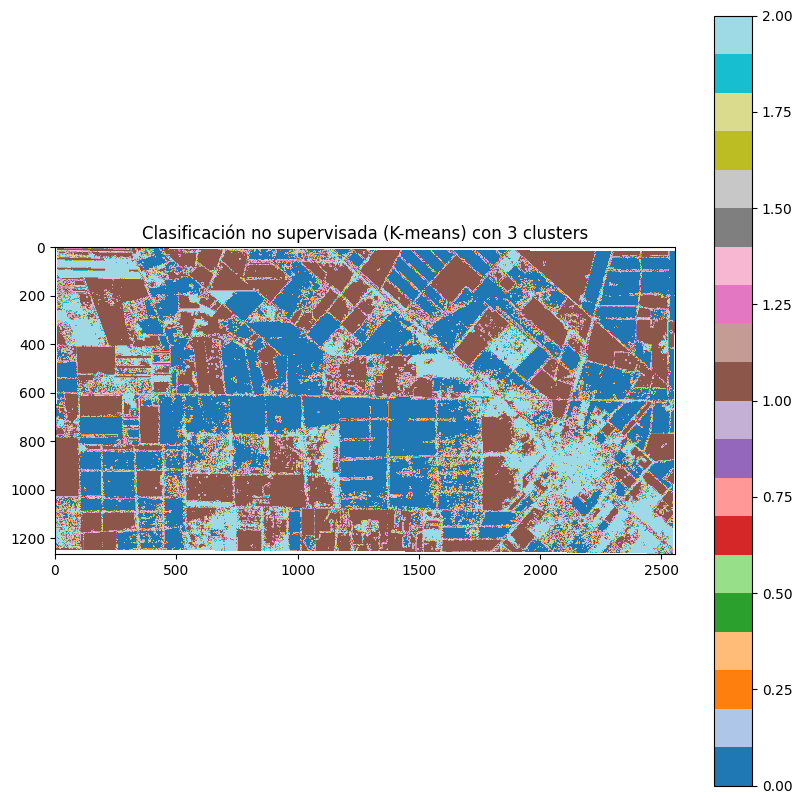

Categoría 0: 12931.34 ha
Categoría 1: 12004.35 ha
Categoría 2: 6931.99 ha


In [ ]:
# Se lee la imagen y se obtiene la resolución espacial
with rasterio.open(image_path) as src:
    bands = []
    for i in range(1, 7):  # Se leen todas las bandas (B2, B3, B4, B8, B11, B12)
        bands.append(src.read(i))
    image = np.stack(bands, axis=-1)  # Stack para crear una matriz de dimensiones (1264, 2556, 6)
    resolution = src.res[0]  # Asumiendo que la resolución es igual para ambas direcciones (m/píxel)

print(f'Resolución espacial: {resolution} metros por píxel')

# Se calcula el área de un píxel en hectáreas (1 ha = 10,000 m²)
pixel_area_ha = (resolution ** 2) / 10000

# Reshape de la imagen para aplicar K-means
pixels = image.reshape(-1, 6)  # Cambia la forma a (1264*2556, 6)

# Manejo de NaNs: se eliminan píxeles con valores NaN
valid_pixels = pixels[~np.isnan(pixels).any(axis=1)]

# Se aplica K-means con el número seleccionado de clusters (3)
n_clusters = 3  # Seleccionado basado en la gráfica del método del codo

kmeans = KMeans(n_clusters=n_clusters, random_state=42).fit(valid_pixels)

# Se crea un arreglo para almacenar las etiquetas y asignar NaN donde corresponda
labels = np.full(pixels.shape[0], np.nan)
labels[~np.isnan(pixels).any(axis=1)] = kmeans.labels_

# Se reestructuran las etiquetas a la forma original de la imagen
labels = labels.reshape(image.shape[0], image.shape[1])

# Se visualizan los resultados
plt.figure(figsize=(10, 10))
plt.imshow(labels, cmap='tab20')
plt.colorbar()
plt.title('Clasificación no supervisada (K-means) con 3 clusters')
plt.show()

# Se cuantifica la superficie de cada categoría
unique, counts = np.unique(labels[~np.isnan(labels)], return_counts=True)
area_per_category = dict(zip(unique, counts * pixel_area_ha))

# Se muestran los resultados
for category, area in area_per_category.items():
    print(f'Categoría {int(category)}: {area:.2f} ha')